<br>
<h1 style = "font-size:40px; font-family:luxury; font-weight:bold; text-align:center; border-radius:10px 15px;">DELE Assignment 2 Part B</h1>
<h1 style = "font-size:40px; font-family:luxury; font-weight:bold; text-align:center; border-radius:10px 15px;">Lunar Lander v2 using Reinforcemnet Learning</h1>

<h2 style="font-family:luxury; text-align:center;">Name: Sih Jia Qi (2036140) & Oh Li Ting (2019334) &nbsp;&nbsp;&nbsp; Class: DAAA/FT/2B/05</h2>
<br>

---

# 1 Introduction

## Reinforcement learning
* The agent takes `actions` and `environment` gives `reward` based on those actions, The goal is to teach the agent optimal behavior in order to `maximize` the reward received by the environment.
<img src="https://miro.medium.com/max/4918/1*Y0TDuXNyywjqqr5l5GkMQQ.png">

## Q-learning vs SARSA
<img src="http://vinitsarode.weebly.com/uploads/1/0/3/7/103702208/screenshot-from-2018-07-08-02-28-03_orig.png">

* For QL, which is the `off-policy` algorithm, when passing the reward from the next state (s_, a_) to the current state, it takes the maximum possible reward of the new state (s_) and ignores whatever policy we are using. 

* Instead of using the Q value estimate for the newstate and the action that the agent took in that new state, it uses the Q value
estimate that corresponds to the action that leads to the maximum obtainable Q value from that new state, S'.

* For SARSA, which is on-policy, we still follow the policy (e-greedy), compute the next state (a_), and pass the reward corresponding to that exact a_ back the previous step.

## How does the Lunar Lander work?
* Landing pad is always at coordinates (0,0) (Coordinates are the first two numbers in state vector)

* Reward for moving from the top of the screen to landing pad and zero speed is about 100..140 points 

* If lander moves away from landing pad it loses reward back

* Episode finishes if the lander crashes or comes to rest, receiving additional -100 or +100 points

* Each leg ground contact is +10

* Firing main engine is -0.3 points each frame 

* Solved is 200 points

* Landing outside landing pad is possible. Fuel is infinite, so an agent can learn to fly and then land on its first attempt.

* For each state in the environment, teh agent takes an action based on its current state. Action space consists of four `discrete actions`: 
> 0: `do nothing`
>
> 1: `fire left` engine
>
> 2: `fire main` engine
>
> 3: `fire right` engine

In [ ]:
!pip3 install box2d-py
!pip3 install gym[Box_2D]

## Importing libraries

In [ ]:
import gym
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import base64, io

import numpy as np
from collections import deque, namedtuple

# for visualization
from gym.wrappers.monitoring import video_recorder
from IPython.display import HTML
from IPython import display 
import glob

In [ ]:
env = gym.make('LunarLander-v2')
env.seed(0)

print('State shape: ', env.observation_space.shape)
print('Number of actions: ', env.action_space.n)

State shape:  (8,)
Number of actions:  4


#2 Model Training and Evaluation
* Agent: Interacts with and learns from the environment.
> The agent’s goal is to find a sequence of actions that will `maximize` the sum of rewards during the course of an episode of the agent.

* Action-value function: 
> Use fixed-size buffer to store experience tuples.
>
> alpha = learning rate
>
> gamma = discount factor 
  * It quantifies how much `importance` we give for future rewards. It’s also handy to approximate the noise in future rewards. Gamma varies from 0 to 1. If Gamma is closer to zero, the agent will tend to consider only immediate rewards. If Gamma is closer to one, the agent will consider future rewards with greater weight, willing to delay the reward.
>
>epsilon = random factor, if we draw a random num < epsilon then we'll take a random action else, takes a greedy action (best known action given in some state)
>
>epsilon_end = min epsilon (not 0 because we do not knw if the greedy action is the best action, therefore we want to continue to explore during training)

In [ ]:
class QNetwork(nn.Module):
    """Actor (Policy) Model"""

    def __init__(self, state_size, action_size, seed):
        """
        Initialize parameters and build model
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
        """
        super(QNetwork, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, action_size)
        
    def forward(self, state):
        """Build a network that maps state -> action values"""
        x = self.fc1(state)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        return self.fc3(x)

In [ ]:
class Agent():
    def __init__(self, state_size, seed, gamma, lr, update_every=4, TAU=1e-3, action_size=4, buffer_size=1000000, batch_size=64):
        """
        Initialize an Agent object
        
        Params
        ======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            seed (int): random seed
            gamma (float): discount factor (tells agent how much to discount feature rewards)
            lr (float): learning rate
            buffer_size (int): memmory size
            batch_size (int): size of the batch
            update_every (int): how often to update the network
            TAU (float): for soft update of target parameters
        """
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(int(seed))
        self.gamma = gamma
        self.lr = lr
        self.buffer_size = buffer_size
        self.batch_size = batch_size
        self.TAU = TAU
        self.update_every = update_every

        # Q-Network
        self.qnetwork_local = QNetwork(self.state_size, self.action_size, seed).to(device)
        self.qnetwork_target = QNetwork(self.state_size, self.action_size, seed).to(device)
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=self.lr)

        # replay memory
        self.memory = ReplayBuffer(self.action_size, self.buffer_size, self.batch_size, seed)
        # initialize time step (for updating every update_every steps)
        self.t_step = 0
    
    def step(self, state, action, reward, next_state, done):
        # save experience in replay memory
        self.memory.add(state, action, reward, next_state, done)
        
        # learn every update_every time steps
        self.t_step = (self.t_step + 1) % self.update_every
        if self.t_step == 0:
            # if enough samples are available in memory, get random subset and learn
            if len(self.memory) > self.batch_size:
                experiences = self.memory.sample()
                self.learn(experiences)

    def act(self, state, eps=0.):
        """
        Returns actions for given state as per current policy
        
        Params
        ======
            state (array_like): current state
            eps (float): epsilon, for epsilon-greedy action selection
        """
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.qnetwork_local.eval()
        with torch.no_grad():
            action_values = self.qnetwork_local(state)
        self.qnetwork_local.train()

        # Epsilon-greedy action selection
        if random.random() > eps:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))

    def learn(self, experiences):
        """
        Update parameters using given batch of experience tuples

        Params
        ======
            experiences (Tuple[torch.Variable]): tuple of (s, a, r, s', done) tuples
        """
        # obtain random minibatch of tuples from D
        states, actions, rewards, next_states, dones = experiences

        # compute and minimize the loss
        # extract next maximum estimated value from target network
        q_targets_next = self.qnetwork_target(next_states).detach().max(1)[0].unsqueeze(1)
        # calculate target value from bellman equation
        q_targets = rewards + self.gamma * q_targets_next * (1 - dones)
        # calculate expected value from local network
        q_expected = self.qnetwork_local(states).gather(1, actions)
        
        # loss calculation (we used Mean squared error)
        loss = F.mse_loss(q_expected, q_targets)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # update target network
        self.soft_update(self.qnetwork_local, self.qnetwork_target, self.TAU)                     

    def soft_update(self, local_model, target_model, tau):
        """
        Soft update model parameters
        θ_target = τ*θ_local + (1 - τ)*θ_target

        Params
        ======
            local_model (PyTorch model): weights will be copied from
            target_model (PyTorch model): weights will be copied to
            tau (float): interpolation parameter 
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)

In [ ]:
class ReplayBuffer:
    def __init__(self, action_size, buffer_size, batch_size, seed):
        """
        Initialize a ReplayBuffer object

        Params
        ======
            action_size (int): dimension of each action (eg. 4)
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
            seed (int): random seed
        """
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)  
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)
    
    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory"""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
    
    def sample(self):
        """Randomly sample a batch of experiences from memory"""
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)
  
        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

In [ ]:
def dqn(n_episodes, max_t, eps_start, eps_end, eps_decay):
    """
    Deep Q-Learning
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
    """
    scores, avg_scores, goals = [], [], [] # list containing scores and average scores from each episode
    scores_window = deque(maxlen=100)      # last 100 scores
    goal = 200
    eps = eps_start                        # initialize epsilon
    for i_episode in range(1, n_episodes+1):
        state = env.reset()
        score = 0
        for t in range(max_t):
            env.render()
            video_recorder.capture_frame()
            action = agent.act(state, eps)
            next_state, reward, done, _ = env.step(action)
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                break 
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        avg_score = np.mean(scores[-100:])# store average scores
        avg_scores.append(avg_score)
        goals.append(goal)                # store goal
        eps = max(eps_end, eps_decay*eps) # decrease epsilon

        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        if np.mean(scores_window)>=250:               # target score to stop training
            print('\nEnvironment solved in {:d} episodes.\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
            torch.save(agent.qnetwork_local.state_dict(), 'checkpoint.pth')
            break
        # torch.save(agent.qnetwork_local.state_dict(), 'checkpoint.pth')  
      
    return scores, avg_scores, goals

In [ ]:
torch.save(agent.qnetwork_local.state_dict(), 'checkpoint.pth')

In [ ]:
torch.load('checkpoint.pth')

OrderedDict([('fc1.weight',
              tensor([[ 6.3507e-02, -4.2757e-01, -1.6183e+00, -9.7542e-01,  6.0339e-01,
                        2.9525e-01,  1.7599e-01,  6.9212e-02],
                      [-5.1497e-01, -1.6910e+00, -1.5493e+00, -5.3854e-01, -2.6074e-01,
                       -3.1229e-01, -2.4328e-02, -5.4171e-01],
                      [-3.9487e-01,  2.0255e-01,  5.0757e-02, -1.7409e-01,  9.0620e-01,
                        5.4814e-01,  2.2936e-01,  4.7603e-01],
                      [ 7.5743e-02,  2.2901e-01, -1.6780e-01, -7.6036e-02, -1.3042e+00,
                       -2.0147e-01, -7.6364e-02,  1.2508e-01],
                      [ 3.6861e-01, -1.8782e+00,  4.7654e-01, -1.4509e+00,  4.7226e-01,
                       -9.0418e-03,  1.0077e-01,  6.0333e-02],
                      [ 7.1226e-01, -6.3910e-01,  3.9137e-01, -8.4085e-01, -7.4822e-01,
                       -1.7150e-01,  1.5146e-01, -3.7786e-03],
                      [ 5.9972e-02, -1.4595e-02,  7.2122e-01,  2.1

In [ ]:
def show_video(env_name):
    mp4list = glob.glob('video/*.mp4')
    if len(mp4list) > 0:
        mp4 = 'video/{}.mp4'.format(env_name)
        video = io.open(mp4, 'r+b').read()
        encoded = base64.b64encode(video)
        display.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
    else:
        print("Could not find video")
        
def show_video_of_model(agent, env_name):
    env = gym.make(env_name)
    vid = video_recorder.VideoRecorder(env, path="video/{}.mp4".format(env_name))
    agent.qnetwork_local.load_state_dict(torch.load('checkpoint.pth'))
    state = env.reset()
    done = False
    while not done:
        frame = env.render(mode='rgb_array')
        vid.capture_frame()
        action = agent.act(state)
        state, reward, done, _ = env.step(action)        
    env.close()

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Baseline Model

In [ ]:
# hyperparameters
gamma = 0.77 
lr = 0.001 
batch_size=128

In [ ]:
agent = Agent(state_size=8, action_size=4, seed=0, gamma=gamma, lr=lr, batch_size=batch_size)
scores , avg_scores, goals = dqn(n_episodes=2000, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.99)

Episode 100	Average Score: -126.69
Episode 200	Average Score: -92.18
Episode 300	Average Score: -51.87
Episode 400	Average Score: -54.63
Episode 500	Average Score: 25.49
Episode 600	Average Score: 13.76
Episode 700	Average Score: 30.63
Episode 800	Average Score: 34.76
Episode 900	Average Score: 15.71
Episode 1000	Average Score: 14.42
Episode 1100	Average Score: -25.21
Episode 1200	Average Score: -4.36
Episode 1300	Average Score: -29.35
Episode 1400	Average Score: -26.60
Episode 1500	Average Score: -38.34
Episode 1600	Average Score: -13.89
Episode 1700	Average Score: -3.74
Episode 1800	Average Score: -34.19
Episode 1900	Average Score: 12.37
Episode 2000	Average Score: 25.91


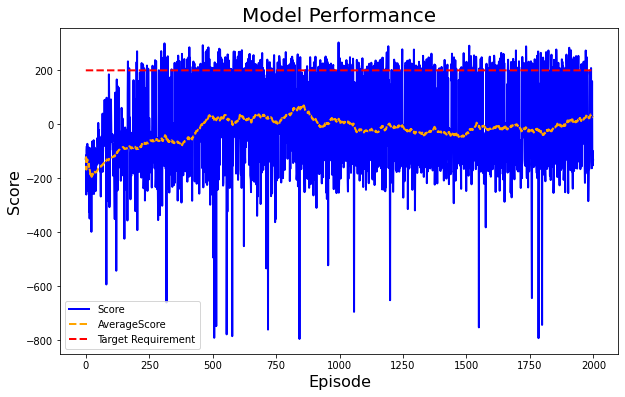

In [ ]:
#visualize model performance
fig = plt.figure(figsize=(10,6))
plt.plot(np.arange(len(scores)), scores, marker='', color='blue', linewidth=2, label='Score')
plt.plot(avg_scores, marker='', color='orange', linewidth=2, linestyle='dashed', label='AverageScore')
plt.plot(np.arange(len(scores)), goals, marker='', color='red', linewidth=2, linestyle='dashed', label='Target Requirement')

plt.title('Model Performance', fontsize=20)
plt.ylabel('Score', fontsize=16)
plt.xlabel('Episode', fontsize=16)
plt.legend()
plt.show()

### Insights
* The baseline model performs `badly` with the highest average score of 25.91 through 2000 episodes.

* The average score diverges and oscillates dramatically.

* From the graph, we can see that there are many `spikes` towards the negative scale, which shows that the Lunar Lander `crashed` or `hit the pole`.


In [ ]:
# show_video_of_model(agent, 'LunarLander-v2')
show_video('LunarLander-v2')

Could not find video


# 3 Model Improvement

* Batch sizes 10, 120, 500, 1000 
* Gamma lists 0.22, 0.55, 0.77, 0.99
* Alpha values 0.00025, 0.001, 0.01, 0.1
* Epsilon Decay 0.999, 0.99, 0.9, 0.1
* Target Model Update Frequency rates 1,50,125,500

## Experiment 1: Decrease learning rate
* Improve the convergence `stability` of the model during training

In [ ]:
# hyperparameters
gamma = 0.77
lr = 0.0001 
batch_size = 128

In [ ]:
agent = Agent(state_size=8, action_size=4, seed=0, gamma=gamma, lr=lr, batch_size=batch_size)
scores , avg_scores, goals = dqn(n_episodes=2000, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995)

Episode 100	Average Score: -166.07
Episode 200	Average Score: -146.94
Episode 300	Average Score: -134.70
Episode 400	Average Score: -102.56
Episode 500	Average Score: -64.71
Episode 600	Average Score: -68.79
Episode 700	Average Score: -33.29
Episode 800	Average Score: -87.73
Episode 900	Average Score: -60.85
Episode 1000	Average Score: -69.35
Episode 1100	Average Score: -76.23
Episode 1200	Average Score: -33.20
Episode 1300	Average Score: -61.01
Episode 1400	Average Score: -35.20
Episode 1500	Average Score: -48.89
Episode 1600	Average Score: -2.70
Episode 1700	Average Score: 7.55
Episode 1800	Average Score: 26.61
Episode 1900	Average Score: 33.49
Episode 2000	Average Score: 23.10


### Insights
* To reduce oscillation and `improve` the `stability` of the model during training

* As shown in the performance graph, the `spikes` are `gone`. 

* The model is able to `converge better` as compared to the baseline model

* However, there are still some `landing failures` occurred during the training 
> ie. Episode 1300 to 1400 (from 3.31 to -19.74)
>
> Episode 1500 to episode 1600 (from 24.49 to -2.38)


## Experiment 2: Increase gamma
* The larger the gamma, the smaller the discount. This means the learning agent cares more about the `long term` reward.


In [ ]:
# hyperparameters
gamma = 0.99 
lr = 0.0001 
batch_size = 128

In [ ]:
agent = Agent(state_size=8, action_size=4, seed=0, gamma=gamma, lr=lr, batch_size=batch_size)
scores , avg_scores, goals = dqn(n_episodes=2000, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995)

Episode 100	Average Score: -208.46
Episode 200	Average Score: -211.22
Episode 300	Average Score: -142.05
Episode 400	Average Score: -43.85
Episode 500	Average Score: -35.62
Episode 600	Average Score: -1.31
Episode 700	Average Score: 25.54
Episode 800	Average Score: 11.02
Episode 900	Average Score: -31.20
Episode 1000	Average Score: -43.95
Episode 1100	Average Score: -48.05
Episode 1200	Average Score: -32.08
Episode 1300	Average Score: -24.09
Episode 1400	Average Score: 1.41
Episode 1500	Average Score: 0.65
Episode 1600	Average Score: 85.43
Episode 1700	Average Score: 40.32
Episode 1800	Average Score: -20.33
Episode 1900	Average Score: -48.30
Episode 2000	Average Score: -49.82


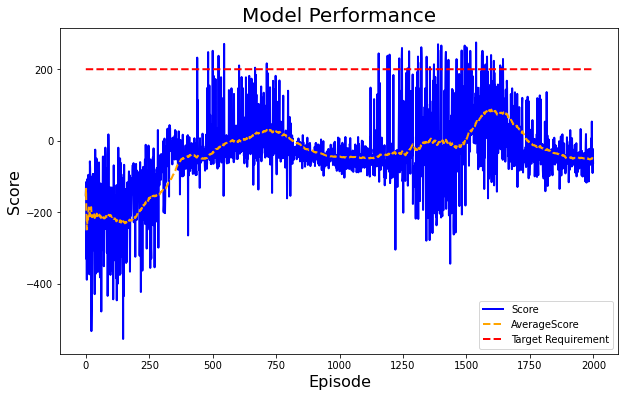

In [ ]:
# plot the scores
fig = plt.figure(figsize=(10,6))

plt.plot(np.arange(len(scores)), scores, marker='', color='blue', linewidth=2, label='Score')
plt.plot(avg_scores, marker='', color='orange', linewidth=2, linestyle='dashed', label='AverageScore')
plt.plot(np.arange(len(scores)), goals, marker='', color='red', linewidth=2, linestyle='dashed', label='Target Requirement')

plt.title('Model Performance', fontsize=20)
plt.ylabel('Score', fontsize=16)
plt.xlabel('Episode', fontsize=16)
plt.legend()
plt.show()

### Insights
* The `larger` the gamma, the `smaller` the discount. This means the learning agent cares more about the long term reward.

* The variance of the average score also `decreases`.

* The average scores are still `far` from the target score set, which is 250.

* The neural network might have difficulties in finding the `optimal global minima`, therefore we `increased` the `learning rate` slightly in the next experiment.

## Experiment 3: Increasing learning rate to find global minima

In [ ]:
# hyperparameters
gamma = 0.99 
lr = 0.0007
batch_size=64

In [ ]:
agent = Agent(state_size=8, action_size=4, seed=0, gamma=gamma, lr=lr, batch_size=batch_size)
scores , avg_scores, goals = dqn(n_episodes=2000, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995)

Episode 100	Average Score: -186.16
Episode 200	Average Score: -147.02
Episode 300	Average Score: -104.69
Episode 400	Average Score: -34.67
Episode 500	Average Score: -28.03
Episode 600	Average Score: -20.91
Episode 700	Average Score: -9.17
Episode 800	Average Score: 51.07
Episode 900	Average Score: 140.73
Episode 1000	Average Score: 191.97
Episode 1100	Average Score: 198.47
Episode 1200	Average Score: 195.50
Episode 1300	Average Score: 234.34
Episode 1400	Average Score: 234.91
Episode 1500	Average Score: 234.25
Episode 1600	Average Score: 232.35
Episode 1700	Average Score: 227.62
Episode 1800	Average Score: 237.39
Episode 1900	Average Score: 230.10
Episode 2000	Average Score: 245.32


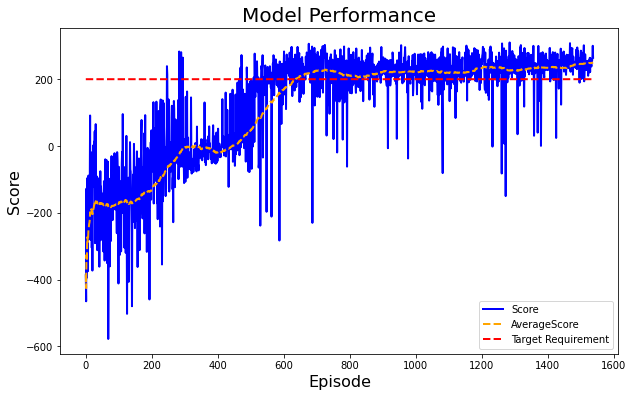

In [ ]:
# plot the scores
fig = plt.figure(figsize=(10,6))

plt.plot(np.arange(len(scores)), scores, marker='', color='blue', linewidth=2, label='Score')
plt.plot(avg_scores, marker='', color='orange', linewidth=2, linestyle='dashed', label='AverageScore')
plt.plot(np.arange(len(scores)), goals, marker='', color='red', linewidth=2, linestyle='dashed', label='Target Requirement')

plt.title('Model Performance', fontsize=20)
plt.ylabel('Score', fontsize=16)
plt.xlabel('Episode', fontsize=16)
plt.legend()
plt.show()

### Insights
* This is the best set of hyperparameters among all experiments.
* The Lunar Lander managed to land perfectly on the landing pad with an average score of 200 and above starting from Episode 600 and continues to increase for the rest of the episodes.
* It reaches our target score of 250 at the 1539th episode. 

# 4 Conclusion and key takeaways
* Hyperparameters such as `learning rate` and `gamma` are crucial in training the Agent. By having a learning rate of 0.001, the Lunar Lander is not able to perform well and faces difficulties in converging. Threfore, we reduced the learning rate and tuned some of th ehyperparameters such as batch size.

* After experimenting several sets of hyperparameters and changing the CNN layers, we managed to `reach` our `goal` of the project, which is to train a Lunar Lander that can `lands properly` and has an `average score` of 200 and above for a continuous of 1000 episodes.

* `Reinforcement Learning` is one of the `most exciting` field of AI among all that we have explored.

*  It is also a challenging task to implement RL algorithm as the Agent learns from scratch (wihout any prior knwoledge).

* In future, we would like to `discover more` on the application of Reinforcement Learning and try to create a `RL game`.